# Project 3

This project requires the implementation of an image classifier based on convolutional neural networks. The provided dataset (from [Lazebnik et al., 2006]),
contains 15 categories (office, kitchen, living room, bedroom, store, industrial,
tall building, inside city, street, highway, coast, open country, mountain, forest,
suburb), and is already divided in training set and test set.

### 1. train a shallow network

Libraries used.

In [1]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import seaborn as sn
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import cv2 as cv2
import numpy as np
import os
import glob

Using TensorFlow backend.


This first part is dedicated to data preprocessing.

In [2]:
#path to the directories
PATH_TRAIN=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\train'
PATH_TEST=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\test'
#array of the class
LABELS=[os.path.basename(dir) for dir in glob.glob(PATH_TRAIN + '/*', recursive=True)]
NUM_CLASSES = len(LABELS)

In [3]:
#function to retrive and reshape training and test sets
def retrieve_from(path):
    y=[]
    x=[]
    width = 64
    height = 64
    channel = 1
    
    for idx,i in enumerate(LABELS):
        for im in glob.glob(path+ '/'+ i +'/*.jpg', recursive=True):
            #color convertion to black and white images
            x.append(cv2.cvtColor(cv2.imread(im),cv2.COLOR_BGR2GRAY))
            y.append(idx)
    #Using anisotropic rescaling, resize the images to 64x64 in order to feed them to the network
    x_new = np.array([cv2.resize(im, (width,height), interpolation = cv2.INTER_AREA) for im in x])
    x_new = np.array([np.reshape(im,(width,height,channel)) for im in x_new])
    #normalize the images
    x_new = x_new / 255
    return x_new,y

In [4]:
X_train_raw, y_train_raw = retrieve_from(PATH_TRAIN)
X_test, y_test = retrieve_from(PATH_TEST)

print('Image Dimensions : ',X_test[0].shape)
print('len train x: ',len(X_train_raw))
print('len test x: ',len(X_test))
print('len train y: ',len(y_train_raw))
print('len test y: ',len(y_test))

Image Dimensions :  (64, 64, 1)
len train x:  1500
len test x:  2985
len train y:  1500
len test y:  2985


Print a sample image to check the correctness of the procedure.

In [ ]:
cv2.imshow("Resized image", X_train_raw[9])
cv2.waitKey(0)
cv2.destroyAllWindows()
#note: remember to close the images to procede

Data manipulation.

In [5]:
# Use One-Hot Encoding to convert the labels into a set of numbers to input into the neural network.
y_train_one_hot = to_categorical(y_train_raw)
y_test_one_hot = to_categorical(y_test)
# Split the training set between train 85% and validation set 15%
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_raw, y_train_one_hot, train_size=0.85, random_state=42)
print('Train set dimintion: ',len(X_train))
print('Validation set dimintion: ',len(X_validation))

Train set dimintion:  1275
Validation set dimintion:  225


To build the model we need to create the given architecture using Sequential() and add the first layer, a convolution layer to extract features from the input image.

In [6]:
# initial weights drawn from a Gaussian distribution with a mean of 0 and a standard deviation of 0.01
norm = ks.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
# employ Stochastic gradient descent with momentum optimization algorithm
sgd = ks.optimizers.SGD(momentum=0.9,nesterov=True)

base_model = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 3,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    #set the initial bias values to 0
    Dense(NUM_CLASSES, activation='softmax',kernel_initializer=norm, bias_initializer='zeros')
])

base_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

Visualize training results, since we don't know the best number of epochs we compute a stopping critera .

In [7]:
es = EarlyStopping(monitor='val_loss', patience=5)
#use batch sized of 32
batch_sz = 32

base_history=base_model.fit(
    X_train,
    y_train,
    batch_size=batch_sz,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Train on 1275 samples, validate on 225 samples
Epoch 1/20
1275/1275 [==============================] - 3s 2ms/step - loss: 2.7038 - accuracy: 0.0863 - val_loss: 2.6794 - val_accuracy: 0.1022
Epoch 2/20
1275/1275 [==============================] - 3s 2ms/step - loss: 2.6015 - accuracy: 0.1522 - val_loss: 2.4721 - val_accuracy: 0.1556
Epoch 3/20
1275/1275 [==============================] - 3s 2ms/step - loss: 2.4179 - accuracy: 0.2322 - val_loss: 2.4888 - val_accuracy: 0.2133
Epoch 4/20
1275/1275 [==============================] - 3s 2ms/step - loss: 2.3023 - accuracy: 0.2949 - val_loss: 2.3898 - val_accuracy: 0.2489
Epoch 5/20
1275/1275 [==============================] - 3s 2ms/step - loss: 2.2289 - accuracy: 0.3239 - val_loss: 2.4707 - val_accuracy: 0.2089
Epoch 6/20
1275/1275 [==============================] - 3s 2ms/step - loss: 2.1296 - accuracy: 0.3514 - val_loss: 2.3698 - val_accuracy: 0.2222
Epoch 7/20
1275/1275 [==============================] - 3s 2ms/step - loss: 1.7757 - accu

Plot the results

In [8]:
#functon to plot the accurancy and loss behaviour
def plot_acc_loss(history):    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

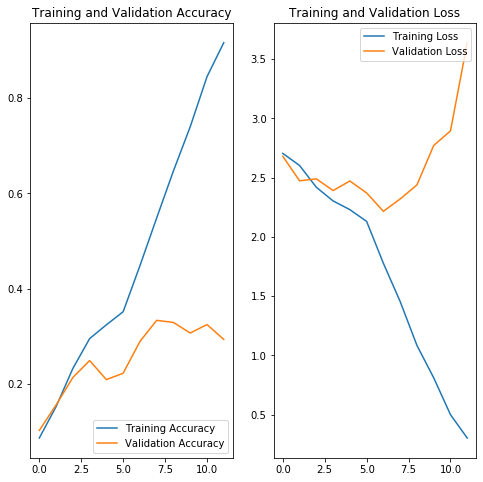

<Figure size 432x288 with 0 Axes>

In [26]:
plot_acc_loss(base_history)
plt.savefig("accurancy and loss base model");

Print the accurancy and loss for the test set

In [27]:
base_loss, base_accuracy = base_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(base_loss))
print("accuracy: {:.2f}".format(base_accuracy))

2985/2985 [==============================] - 2s 651us/step
loss: 3.42
accuracy: 0.32


Plot normalized confusion matrix

In [28]:
def plot_confusion_matrix(test_y,y_pred):
    cm=confusion_matrix(test_y, y_pred)
    # Normalize the confusion matrix so that each row sums to 1.
    cm = tf.cast(cm, dtype=tf.float32)
    cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]
    plt.figure(figsize=(18,13))
    sn.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS);
    plt.xlabel("Predicted");
    plt.ylabel("True");

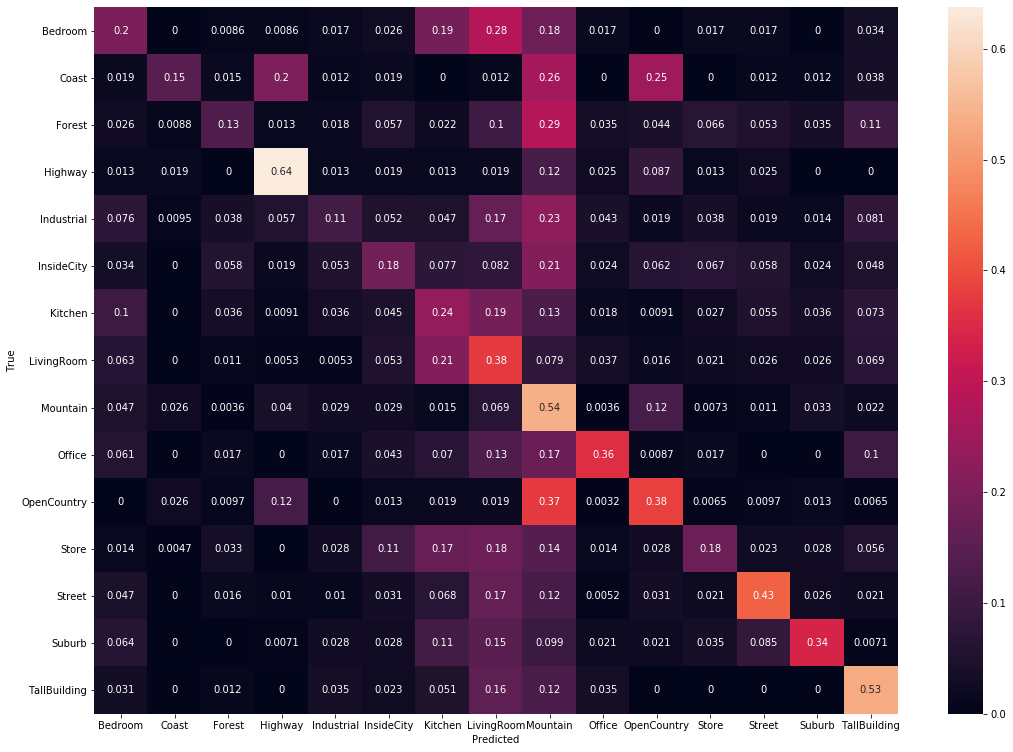

In [29]:
y_pred_base = base_model.predict_classes(X_test)
plot_confusion_matrix(y_test,y_pred_base)
plt.savefig("confusion matrix base model");

In [30]:
print('Classification Report')
print(classification_report(y_test, y_pred_base, target_names=LABELS))

Classification Report
              precision    recall  f1-score   support

     Bedroom       0.18      0.20      0.19       116
       Coast       0.62      0.15      0.24       260
      Forest       0.38      0.13      0.19       228
     Highway       0.45      0.64      0.53       160
  Industrial       0.29      0.11      0.16       211
  InsideCity       0.26      0.18      0.22       208
     Kitchen       0.12      0.24      0.16       110
  LivingRoom       0.19      0.38      0.25       189
    Mountain       0.22      0.54      0.31       274
      Office       0.43      0.36      0.39       115
 OpenCountry       0.42      0.38      0.40       310
       Store       0.38      0.18      0.24       215
      Street       0.54      0.43      0.48       192
      Suburb       0.48      0.34      0.40       141
TallBuilding       0.53      0.53      0.53       256

    accuracy                           0.32      2985
   macro avg       0.36      0.32      0.31      2985
weig

### 2. Optimize the results

Since we get an accurancy of nearly 30% in the test set we try to improve the results by the following tecniques.

#### Data augmentation

given the small training set, data augmentation is likely to improve the performance. For the problem at hand,
left-to-right reflections are a reasonable augmentation technique.

In [18]:
data_generator = ImageDataGenerator(horizontal_flip=True)
train_aug = data_generator.flow(X_train, y_train, batch_size=32)

In [ ]:
history_augmented=base_model.fit(
    train_aug,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

In [ ]:
plot_acc_loss(history_augmented)
plt.savefig("accurancy and loss model whit augmented data");

In [ ]:
y_pred_aug = base_model.predict_classes(X_test)
loss0,accuracy0 = base_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(y_test,y_pred_aug)
plt.savefig("confusion matrix first model with data augmented");

#### Batch normalization

Add batch normalization layers before the reLU layers

In [10]:
def norm_model():
    norm_model = Sequential([
            Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
            BatchNormalization(axis=-1),
            Activation('relu'),
            MaxPooling2D(pool_size=2,strides=2),
            Conv2D(16, 3,strides=1, padding='same'),
            BatchNormalization(axis=-1),
            Activation('relu'),
            MaxPooling2D(pool_size=2,strides=2),
            Conv2D(32, 3,strides=1, padding='same'),
            BatchNormalization(axis=-1),
            Activation('relu'),
            Flatten(),
            Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
            Activation('softmax')])

    norm_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    return norm_model

In [ ]:
history_norm=norm_model().fit(
    X_train,
    y_train,
    batch_size=batch_sz,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

As we can see from the accurancy in the training set this model is probably affected by overfitting.

In [ ]:
plot_acc_loss(history_norm)
plt.savefig("accurancy and loss model after adding batch normalization layers");

In [ ]:
y_pred_norm = norm_model().predict_classes(X_test)
loss,accuracy = norm_model().evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

plot_confusion_matrix(y_test,y_pred_norm)
plt.savefig("confusion matrix second model");

We try train this model with the augmented data to reduce the overfitting.

In [ ]:
history_norm_data_augmeted=norm_model().fit(
    train_aug,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

In [ ]:
y_pred_norm_data_augmeted = norm_model().predict_classes(X_test)
loss,accuracy = norm_model().evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

In [ ]:
plot_confusion_matrix(y_test,y_pred_norm_data_augmeted)
plt.savefig("confusion matrix second model whit data augm");

As we can see the performance increases, so from now we will use data augmented to train our model.

#### Add and Resize convolutional filters

Increase the support of convolutional filters as we move from input to output:
3×3, 5×5, 7×7

In [11]:
def model_res():
    model_res = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        Conv2D(16, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 7,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    model_res.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    return model_res

In [ ]:
history_res=model_res().fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

In [ ]:
plot_acc_loss(history_res)
plt.savefig("accurancy and loss model after resizing layers");

In [ ]:
y_pred_res = model_res().predict_classes(X_test)
loss,accuracy = model_res().evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

plot_confusion_matrix(y_test,y_pred_res)
plt.savefig("confusion matrix third model");

As we can see this optimized tecnique seems not to bring improvements. Probably this is because small kernel can detects more relevant features. But considering the accurancy this model seems to be far from overfitting, for that reasons we add a batch normalization layer after the first convolutional layers.

We try to run normalize model with these kind of manipulation

In [12]:
def model_res_norm():
    model_res_norm = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        Conv2D(16, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 7,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
        ])
    model_res_norm.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model_res_norm

In [ ]:
history_res_norm=model_res_norm().fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

In [ ]:
y_pred_res_norm = model_res_norm().predict_classes(X_test)
loss,accuracy = model_res_norm().evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

plot_confusion_matrix(y_test,y_pred_res_norm)
plt.savefig("confusion matrix fourth model");

#### Optimization parameter change

Weight regularization provides an approach to reduce the overfitting of a deep learning neural network model on the training data and improve the performance of the model on new data, such as the holdout test set.

There are multiple types of weight regularization, such as L1 and L2 vector norms, and each requires a hyperparameter that must be configured. In our case we add a l2 regularizer on layers.

In [13]:
def model_opt_not_resized():
    model_opt_not_resized = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 3,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(NUM_CLASSES, activation='softmax',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))
    ])
    #we switch to the Adam optimizer
    model_opt_not_resized.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model_opt_not_resized

In [ ]:
history_opt_not_resized=model_opt_not_resized().fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

In [ ]:
plot_acc_loss(history_opt_not_resized)
plt.savefig("accurancy and loss fifth model");

In [ ]:
y_pred_opt_not_resized = model_opt_not_resized().predict_classes(X_test)
loss,accuracy = model_opt_not_resized().evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

plot_confusion_matrix(y_test,y_pred_opt_not_resized)
plt.savefig("confusion matrix fifth model");

We get a better accurancy but with a high loss and also our data seams to by affected by overfitting.

#### Dropout

We add some dropout layer to improve regularization. Introducing dropout layers to the network is a form of regularization that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples.

In [14]:
def model_dr():
    model_dr = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(16, 3,strides=1, padding='same'),
        Conv2D(16, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(32, 7,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    model_dr.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model_dr

In [ ]:
history_dr=model_dr().fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

In [ ]:
plot_acc_loss(history_dr)
plt.savefig("accurancy and loss model after dropout");

In [ ]:
y_pred_dr = model_dr().predict_classes(X_test)
loss,accuracy = model_dr().evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

plot_confusion_matrix(y_test,y_pred_dr)
plt.savefig("confusion matrix sixth model");

I try to write a model combining all the tecniques.

In [15]:
def model_dr_mod():
    model_dr_mod = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(16, 3,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    model_dr_mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model_dr_mod

In [ ]:
history_dr_mod=model_dr_mod().fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

In [ ]:
y_pred_dr_mod() = model_dr_mod().predict_classes(X_test)
loss,accuracy = model_dr_mod().evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

plot_confusion_matrix(y_test,y_pred_dr_mod)
plt.savefig("confusion matrix seventh model");

Combining the tecniques we get one of the best score.

#### Ensemble of networks

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses. So we try to combine our previously models.

In [16]:
np.random.seed(17) # My lucky number

trained_models=[]
trained_models.append(norm_model())
trained_models.append(model_res())
trained_models.append(model_res_norm())
trained_models.append(model_opt_not_resized())
trained_models.append(model_dr())
trained_models.append(model_dr_mod())

In [19]:
set_of_models=[]
# Start multiple model training with the batch size
for i in range(len(trained_models)):    
    trained_models[i].fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
    )
    set_of_models.append(trained_models[i])

Epoch 1/30
40/40 [==============================] - 5s 130ms/step - loss: 3.2415 - accuracy: 0.2329 - val_loss: 2.6278 - val_accuracy: 0.1156
Epoch 2/30
40/40 [==============================] - 5s 113ms/step - loss: 1.5449 - accuracy: 0.5106 - val_loss: 3.0131 - val_accuracy: 0.0578
Epoch 3/30
40/40 [==============================] - 4s 111ms/step - loss: 1.0899 - accuracy: 0.6635 - val_loss: 3.9213 - val_accuracy: 0.0933
Epoch 4/30
40/40 [==============================] - 4s 111ms/step - loss: 0.7747 - accuracy: 0.7545 - val_loss: 3.8802 - val_accuracy: 0.0844
Epoch 5/30
40/40 [==============================] - 5s 120ms/step - loss: 0.5889 - accuracy: 0.8188 - val_loss: 3.8316 - val_accuracy: 0.1022
Epoch 6/30
40/40 [==============================] - 5s 116ms/step - loss: 0.4336 - accuracy: 0.8659 - val_loss: 4.6796 - val_accuracy: 0.0978
Epoch 1/30
40/40 [==============================] - 8s 203ms/step - loss: 2.7088 - accuracy: 0.0612 - val_loss: 2.7044 - val_accuracy: 0.0489
Epoch 

In [22]:
# Predict labels with models
lb = []
for m in set_of_models:
    predicts = m.predict_classes(X_test)
    lb.append(predicts)
    
# Ensemble with voting
lb = np.array(lb)
lb = np.transpose(lb)
lb = scipy.stats.mode(lb,axis=1)[0]


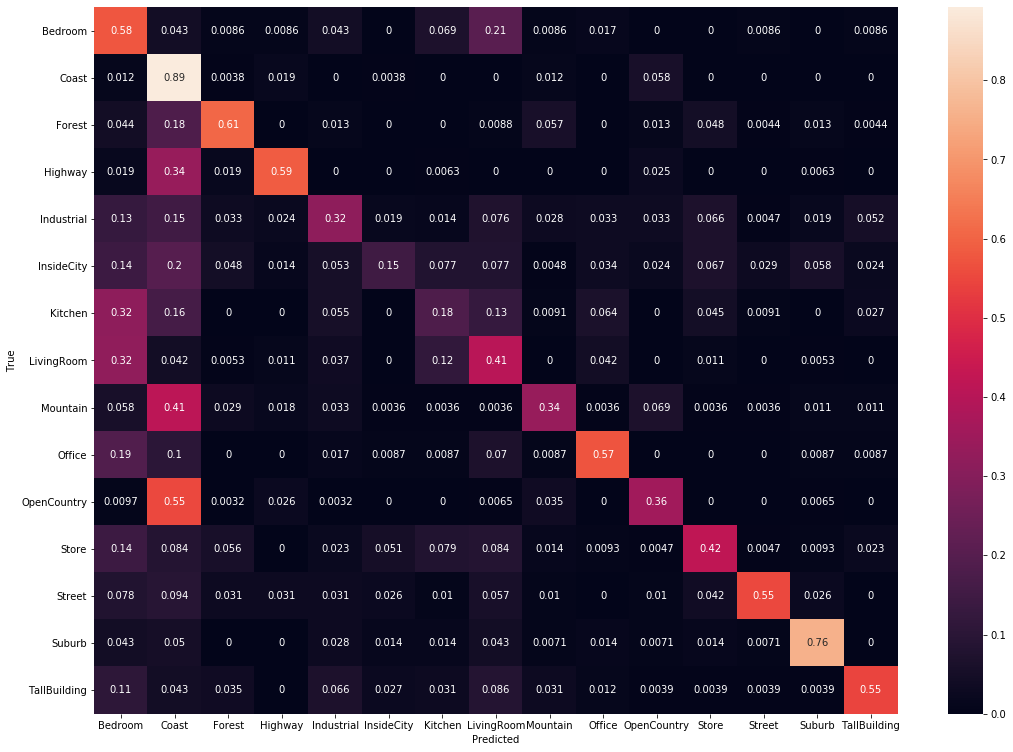

In [24]:
plot_confusion_matrix(y_test,lb)
plt.savefig("confusion matrix ensamble of networks model");

In [25]:
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, lb, target_names=LABELS))

Classification Report
              precision    recall  f1-score   support

     Bedroom       0.19      0.58      0.29       116
       Coast       0.30      0.89      0.44       260
      Forest       0.70      0.61      0.65       228
     Highway       0.73      0.59      0.65       160
  Industrial       0.47      0.32      0.38       211
  InsideCity       0.49      0.15      0.23       208
     Kitchen       0.20      0.18      0.19       110
  LivingRoom       0.35      0.41      0.38       189
    Mountain       0.64      0.34      0.44       274
      Office       0.63      0.57      0.60       115
 OpenCountry       0.66      0.36      0.46       310
       Store       0.61      0.42      0.50       215
      Street       0.88      0.55      0.68       192
      Suburb       0.75      0.76      0.76       141
TallBuilding       0.82      0.55      0.66       256

    accuracy                           0.48      2985
   macro avg       0.56      0.48      0.49      2985
weig